# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls_df = pd.read_csv('../megaline_calls.csv')
internet_df = pd.read_csv('../megaline_internet.csv')
messages_df = pd.read_csv('../megaline_messages.csv')
plans_df = pd.read_csv('../megaline_plans.csv')
users_df = pd.read_csv('../megaline_users.csv')

## Exploración y Preparación de los datos

### Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans_df.info()
print()

plans_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes



Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')

In [4]:
# Imprime una muestra de los datos para las tarifas
plans_df

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


En `plans_df` encontramos las características de los planes Surf y Ultimate, como la cantidad de mensajes incluidos, mb incluidos y minutos incluidos, así como el costo para cada uno de los planes.

De igual manera encontramos las tarifas aplicables para cada plan en caso de exceder la cantidad de mensajes, mb, y minutos incluidos.

En este `df` no encontramos ninguna anomalia en los datos, como duplicados o datos faltantes.

#### Corrección de datos

Convertimos los mb incluidos a gb para un mejor análisis de los datos, ya que el cobro de datos extra es por gb.

In [5]:
plans_df['mb_per_month_included'] = plans_df['mb_per_month_included'] / 1024
plans_df.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


#### Enriquecimiento de datos

Renombramos la columna `mb_per_month_included` por `gb_included`

In [6]:
plans_df = plans_df.rename(columns={'mb_per_month_included':'gb_included'})
plans_df.head()

,messages_included,gb_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


### Usuarios

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users_df.info()
print()

users_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB



Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date'],
      dtype='object')

Revisamos si existen duplicados en el `df`.

In [8]:
users_df.duplicated().sum()

0

In [9]:
# Imprime una muestra de datos para usuarios
users_df.sample(5)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
449,1449,Boyd,Kelley,39,"Seattle-Tacoma-Bellevue, WA MSA",2018-10-04,surf,NaN
59,1059,Avril,Richardson,34,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-22,ultimate,NaN
311,1311,Cherlyn,Saunders,69,"Memphis, TN-MS-AR MSA",2018-06-27,ultimate,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN


Observamos en `users_df` los datos de cada usuario como id, nombre, apellido, ciudad donde viven, tipo de plan que usan, así como 2 fechas 1 que representan cuando el usuario se registró con ese plan y otra que nos dice cuando dejó de usar el plan, en ésta última tenemos datos ausentes, los cuales se deben a que el usaurio aún esta utilizando el plan.

En las columnas `reg_date` y `churn_date` el tipo de datos es `object`, debemos transformar estos datos a tipo `datetime` para un mejor análisis de los datos.

#### Corrección de datos

Cambiamos el tipo `object` de las columnas `reg_date` y `churn_date` a tipo `datetime`.

In [10]:
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'])
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


Cambiamos el nombre de la columna `plan` por `plan_name` para homologar la información con `plans_df`.

In [11]:
users_df = users_df.rename(columns={'plan':'plan_name'})
users_df.head()


,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


#### Enriquecimiento de datos

Extraemos los meses de las columnas `reg_date` y `churn_date` para poder analizar los usuarios registrados o dados de baja por mes para mejorar nuestro análisis de los datos.

In [12]:
users_df['reg_month'] = users_df['reg_date'].dt.month
users_df['churn_month'] = users_df['churn_date'].dt.month
users_df[users_df['churn_month']>0].head()


,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date,reg_month,churn_month
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,11,12.0
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,6,11.0
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,4,9.0
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30,12,12.0
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,3,10.0


## Llamadas

In [13]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls_df.info()
print()

calls_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB



Index(['id', 'user_id', 'call_date', 'duration'], dtype='object')

Revisamos si existen duplicados en el `df`.

In [14]:
calls_df.duplicated().sum()

0

In [15]:
# Imprime una muestra de datos para las llamadas
calls_df.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Observamos en `calls_df` los datos de cada llamada realizada como id de la llamada, usuario que realizó la llamada, fecha en que se realizó la llamada y la duración de la llamada en minutos, no encontramos datos ausentes ni duplicados.

En la columna de `call_date` tipo de datos es `object`, debemos transformar estos datos a tipo `datetime` para un mejor análisis de los datos.


#### Corrección de datos

Cambiamos el tipo `object` de la columna `call_date` a tipo `datetime`.

In [16]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
calls_df.info()
calls_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Enriquecimiento de datos

Extraemos el mes de la columna `call_date` para poder analizar las llamadas realizadas por mes para mejorar nuestro análisis de los datos.

In [17]:
calls_df['month'] = calls_df['call_date'].dt.month
calls_df.sample(5)

,id,user_id,call_date,duration,month
15620,1061_562,1061,2018-12-10,3.86,12
129468,1465_926,1465,2018-08-03,0.00,8
73553,1261_311,1261,2018-11-20,8.11,11
58574,1211_183,1211,2018-12-08,12.08,12
49564,1179_223,1179,2018-07-30,0.92,7


## Mensajes

In [18]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages_df.info()
print()
messages_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB



Index(['id', 'user_id', 'message_date'], dtype='object')

Revisamos si existen duplicados en el `df`.

In [19]:
messages_df.duplicated().sum()

0

In [20]:
# Imprime una muestra de datos para los mensajes
messages_df.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Observamos en `messages_df` los datos de cada mensaje enviado como id del mensaje, usuario que envió el mensaje y la fecha en que se envió el mensaje, no encontramos datos ausentes ni duplicados.

En la columna de `message_date` tipo de datos es `object`, debemos transformar estos datos a tipo `datetime` para un mejor análisis de los datos.


### Corrección de datos

Cambiamos el tipo `object` de la columna `messsage_date` a tipo `datetime`.

In [21]:
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])
messages_df.info()
messages_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Enriquecimiento de datos

Extraemos el mes de la columna `message_date` para poder analizar los mensajes enviados por mes para mejorar nuestro análisis de los datos.

In [22]:
messages_df['month'] = messages_df['message_date'].dt.month
messages_df.sample(5)

,id,user_id,message_date,month
74078,1475_212,1475,2018-08-10,8
70586,1460_46,1460,2018-11-10,11
57858,1365_14,1365,2018-10-14,10
51245,1331_420,1331,2018-10-06,10
32803,1203_448,1203,2018-09-17,9


## Internet

In [23]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet_df.info()
print()
internet_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB



Index(['id', 'user_id', 'session_date', 'mb_used'], dtype='object')

Revisamos si existen duplicados en el `df`.

In [24]:
internet_df.duplicated().sum()

0

In [25]:
# Imprime una muestra de datos para el tráfico de internet
internet_df.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Observamos en `internet_df` los datos del uso de internet como id de sesión, usuario que estuvó en sesión, la fecha de la sesión y la cantidad de mb consumidos en la sesión, no encontramos datos ausentes ni duplicados.

En la columna de `session_date` tipo de datos es `object`, debemos transformar estos datos a tipo `datetime` para un mejor análisis de los datos.


### Corrección de datos

Cambiamos el tipo `object` de la columna `session_date` a tipo `datetime`.

In [26]:
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])
internet_df.info()
internet_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Enriquecimiento de datos

Extraemos el mes de la columna `session_date` para poder analizar el consumo de internet por mes para mejorar nuestro análisis de los datos.

In [27]:
internet_df['month'] = internet_df['session_date'].dt.month
internet_df.sample(5)

,id,user_id,session_date,mb_used,month
89802,1414_258,1414,2018-09-09,61.82,9
43098,1191_277,1191,2018-12-23,310.28,12
71679,1334_247,1334,2018-06-05,199.40,6
30776,1141_44,1141,2018-11-11,0.00,11
9156,1046_441,1046,2018-06-30,554.95,6


## Estudiar las condiciones de las tarifas

Es importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción por loq eu una vez más echaremos un vistazo a plans_df para analizar la información.

In [28]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans_df

,messages_included,gb_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

Con los datos limpios procedemos a agrupar la información por usuario y mes para facilitar el análisis de los datos.

In [29]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user = calls_df.groupby(['user_id','month'])['id'].count().rename('calls_per_month').reset_index()
calls_per_user.head()


,user_id,month,calls_per_month
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [30]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
min_per_user = calls_df.groupby(['user_id','month'])['duration'].sum().rename('min_per_month').reset_index()
min_per_user.head()


,user_id,month,min_per_month
0,1000,12,116.83
1,1001,8,171.14
2,1001,9,297.69
3,1001,10,374.11
4,1001,11,404.59


Realizamos el redondeo de los minutos para facilitar el análisis de los datos.

In [31]:
min_per_user['min_per_month'] = np.ceil(min_per_user['min_per_month'])
min_per_user.head()

,user_id,month,min_per_month
0,1000,12,117.0
1,1001,8,172.0
2,1001,9,298.0
3,1001,10,375.0
4,1001,11,405.0


In [32]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_user = messages_df.groupby(['user_id','month'])['id'].count().rename('messages_per_month').reset_index()
messages_per_user.head()


,user_id,month,messages_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [33]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
mb_per_user = internet_df.groupby(['user_id','month'])['mb_used'].sum().rename('mb_per_month').reset_index()
mb_per_user.head()


,user_id,month,mb_per_month
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


In [34]:
mb_per_user['mb_per_month'] = np.ceil(mb_per_user['mb_per_month'])
mb_per_user.head()


,user_id,month,mb_per_month
0,1000,12,1902.0
1,1001,8,6920.0
2,1001,9,13315.0
3,1001,10,22331.0
4,1001,11,18505.0


Convertimos los mb a gb ya que la comparación con los datos incluidos esta en gb.

In [35]:
mb_per_user['mb_per_month'] = mb_per_user['mb_per_month'] / 1024
mb_per_user = mb_per_user.rename(columns={'mb_per_month':'gb_per_month'})
mb_per_user.head()

,user_id,month,gb_per_month
0,1000,12,1.857422
1,1001,8,6.757812
2,1001,9,13.002930
3,1001,10,21.807617
4,1001,11,18.071289


Redondeamos los gb para un mejor análisis de los datos.

In [36]:
mb_per_user['gb_per_month'] = np.ceil(mb_per_user['gb_per_month'])


In [37]:
mb_per_user.head()


,user_id,month,gb_per_month
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0


Una vez agrupados los datos, procedemos a unir todos los dataframes en uno solo para facilitar nuestro análisis.

In [38]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
user_monthly_revenue = min_per_user.merge(messages_per_user,on=['user_id','month'],how='outer')
user_monthly_revenue = user_monthly_revenue.merge(mb_per_user,on=['user_id','month'],how='outer')
user_monthly_revenue.head()


,user_id,month,min_per_month,messages_per_month,gb_per_month
0,1000,12,117.0,11.0,2.0
1,1001,8,172.0,30.0,7.0
2,1001,9,298.0,44.0,14.0
3,1001,10,375.0,53.0,22.0
4,1001,11,405.0,36.0,19.0


In [39]:
# Añade la información de la tarifa
users_plans = users_df[['user_id','plan_name','city']]
user_monthly_revenue = user_monthly_revenue.merge(users_plans,on=['user_id'],how='outer')
user_monthly_revenue.head()


,user_id,month,min_per_month,messages_per_month,gb_per_month,plan_name,city
0,1000,12.0,117.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8.0,172.0,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9.0,298.0,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10.0,375.0,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11.0,405.0,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"


In [40]:
user_monthly_revenue = user_monthly_revenue.merge(plans_df,on=['plan_name'],how='outer')
user_monthly_revenue.sample(5)


,user_id,month,min_per_month,messages_per_month,gb_per_month,plan_name,city,messages_included,gb_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
1430,1439,10.0,295.0,77.0,18.0,surf,"Riverside-San Bernardino-Ontario, CA MSA",50,15.0,500,20,10,0.03,0.03
739,1223,8.0,704.0,22.0,20.0,surf,"Phoenix-Mesa-Chandler, AZ MSA",50,15.0,500,20,10,0.03,0.03
1882,1202,11.0,477.0,NaN,12.0,ultimate,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",1000,30.0,3000,70,7,0.01,0.01
1375,1414,12.0,428.0,54.0,30.0,surf,"Urban Honolulu, HI MSA",50,15.0,500,20,10,0.03,0.03
1952,1247,11.0,558.0,121.0,18.0,ultimate,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,30.0,3000,70,7,0.01,0.01


In [41]:
user_monthly_revenue = user_monthly_revenue.fillna(0)
user_monthly_revenue.sample(5)

,user_id,month,min_per_month,messages_per_month,gb_per_month,plan_name,city,messages_included,gb_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
836,1259,3.0,154.0,17.0,2.0,surf,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,15.0,500,20,10,0.03,0.03
402,1122,8.0,473.0,22.0,29.0,surf,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",50,15.0,500,20,10,0.03,0.03
799,1251,7.0,549.0,39.0,23.0,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15.0,500,20,10,0.03,0.03
1303,1396,10.0,280.0,39.0,19.0,surf,"Salt Lake City, UT MSA",50,15.0,500,20,10,0.03,0.03
1408,1431,12.0,634.0,39.0,24.0,surf,"Sacramento–Roseville–Folsom, CA MSA",50,15.0,500,20,10,0.03,0.03


Calculamos los minutos, mensajes y mb extra que cada usuario utilizó por encima de los ya incluidos en su respectivo paquete, para poder obtener el total en USD que deberá pagar.

In [42]:
user_monthly_revenue['min_extra'] =  (user_monthly_revenue['min_per_month'] - user_monthly_revenue['minutes_included']).clip(lower=0)
user_monthly_revenue['messages_extra'] =  (user_monthly_revenue['messages_per_month'] - user_monthly_revenue['messages_included']).clip(lower=0)
user_monthly_revenue['gb_extra'] = (user_monthly_revenue['gb_per_month'] - user_monthly_revenue['gb_included']).clip(lower=0)

In [43]:
user_monthly_revenue.sample(5)

,user_id,month,min_per_month,messages_per_month,gb_per_month,plan_name,city,messages_included,gb_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,min_extra,messages_extra,gb_extra
774,1240,12.0,1056.0,18.0,41.0,surf,"Baton Rouge, LA MSA",50,15.0,500,20,10,0.03,0.03,556.0,0.0,26.0
540,1165,11.0,115.0,42.0,19.0,surf,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,4.0
1461,1452,12.0,35.0,4.0,1.0,surf,"Tucson, AZ MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0
959,1295,12.0,423.0,21.0,22.0,surf,"Kansas City, MO-KS MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,7.0
1047,1322,12.0,128.0,0.0,17.0,surf,"Fresno, CA MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,2.0


Calculamos el total en USD a apagar por cada cliente.

In [44]:
# Calcula el ingreso mensual para cada usuario
user_monthly_revenue['revenue'] = user_monthly_revenue['usd_monthly_pay'] + (user_monthly_revenue['min_extra'] * user_monthly_revenue['usd_per_minute']) + (user_monthly_revenue['messages_extra'] * user_monthly_revenue['usd_per_message']) + (user_monthly_revenue['gb_extra'] * user_monthly_revenue['usd_per_gb'])
user_monthly_revenue.sample(5)

,user_id,month,min_per_month,messages_per_month,gb_per_month,plan_name,city,messages_included,gb_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,min_extra,messages_extra,gb_extra,revenue
594,1177,11.0,261.0,18.0,12.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,20.00
1701,1063,12.0,95.0,0.0,10.0,ultimate,"New York-Newark-Jersey City, NY-NJ-PA MSA",1000,30.0,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.00
341,1106,8.0,564.0,0.0,24.0,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15.0,500,20,10,0.03,0.03,64.0,0.0,9.0,111.92
1574,1498,12.0,325.0,0.0,23.0,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,8.0,100.00
1323,1400,4.0,458.0,0.0,15.0,surf,"Riverside-San Bernardino-Ontario, CA MSA",50,15.0,500,20,10,0.03,0.03,0.0,0.0,0.0,20.00


## Estudia el comportamiento de usuario

Necesitamos estudiar algunas estadísticas descriptivas para los datos agregados y fusionados, que nos sean útiles y que muestren un panorama general captado por los datos. Realizaremos gráficos útiles para facilitar la comprensión y poder comparar las tarifas y decidir cuál es más rentable.

### Llamadas

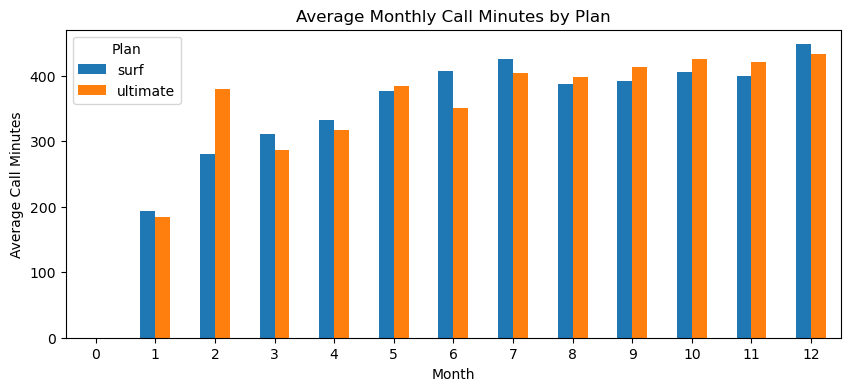

In [45]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
monthly_avg_calls = user_monthly_revenue.groupby(['plan_name','month'])['min_per_month'].mean().reset_index()

# Convertimos los meses a enteros para que no se muestreen como float
monthly_avg_calls['month']  = monthly_avg_calls['month'].astype(int)

# Pivotamos para que cada columna sea un plan
monthly_avg_calls_pivot = monthly_avg_calls.pivot(index='month', columns='plan_name', values='min_per_month')

monthly_avg_calls_pivot.plot(kind='bar', figsize=(10,4))

plt.title('Average Monthly Call Minutes by Plan')
plt.xlabel('Month')
plt.ylabel('Average Call Minutes')
plt.legend(title='Plan')
plt.xticks(rotation=0)
plt.show()

Podemos observar en el gráfico que los usuarios de ambos planes tienen un consumo parecido a lo largo de los meses, excepto en Febrero donde si hubo mayor consumo por parte de los usuarios del plan `Ultimate`.

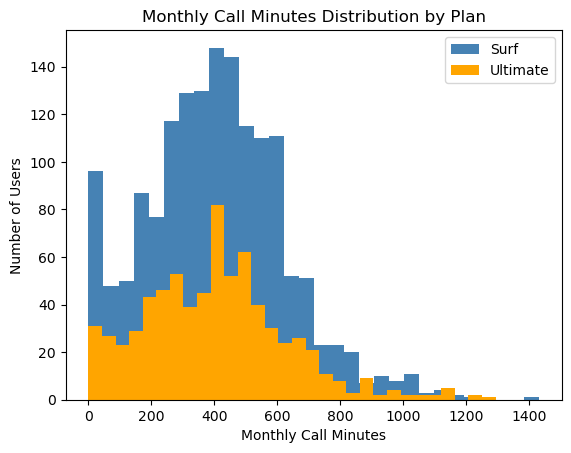

In [46]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
surf_minutes = user_monthly_revenue[user_monthly_revenue['plan_name'] == 'surf']['min_per_month']
ultimate_minutes = user_monthly_revenue[user_monthly_revenue['plan_name'] == 'ultimate']['min_per_month']

plt.hist(surf_minutes, bins=30, label='Surf', color='steelblue')
plt.hist(ultimate_minutes, bins=30, label='Ultimate', color='orange')

# Títulos y etiquetas
plt.title('Monthly Call Minutes Distribution by Plan')
plt.xlabel('Monthly Call Minutes')
plt.ylabel('Number of Users')
plt.legend()
plt.show()


Podemos observar en el histograma que ambos planes tiene una distribución similar en cuanto al consumo de minutos.

In [47]:
# Calcula la media y la varianza de la duración mensual de llamadas.
stats_by_plan = user_monthly_revenue.groupby('plan_name')['min_per_month'].agg(['mean', 'var'])

print(stats_by_plan)


                 mean           var
plan_name                          
surf       403.708676  49577.533581
ultimate   404.458564  52274.176704


Podemos notar que la media y la varianza son muy similares en ambos planes, lo que habíamos notado en los gráficos anteriores.

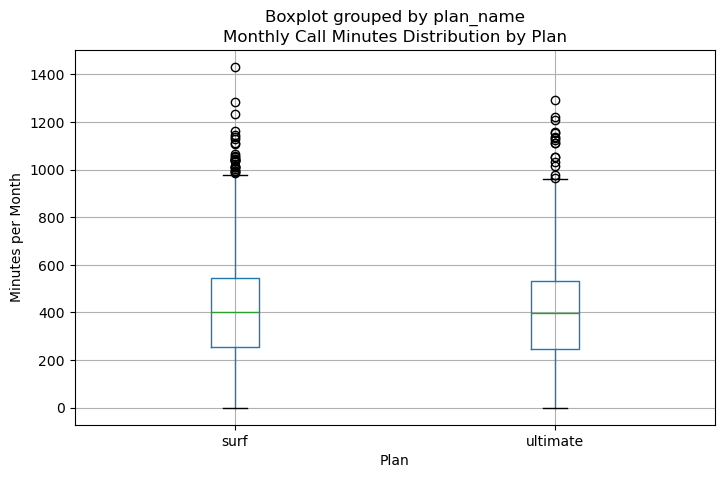

In [48]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
user_monthly_revenue.boxplot(column='min_per_month', by='plan_name', figsize=(8, 5))

plt.title('Monthly Call Minutes Distribution by Plan')
plt.xlabel('Plan')
plt.ylabel('Minutes per Month')
plt.show()


Podemos concluir que los usuarios de ambos planes tienen un comportamiento similar en cuanto al consumo de minutos de llamadas.

### Mensajes

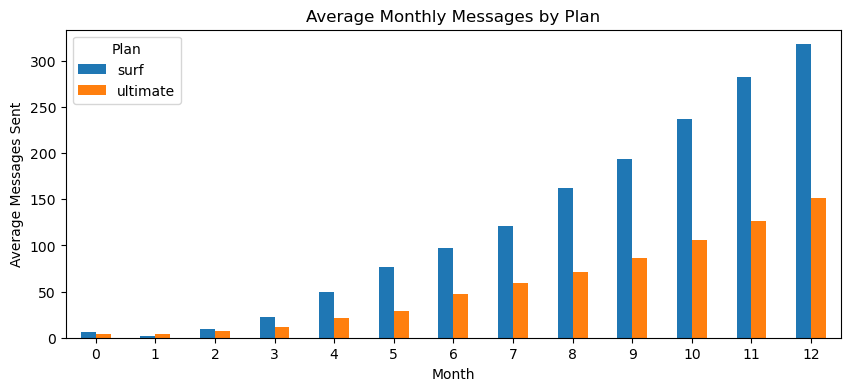

In [49]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
monthly_avg_calls = user_monthly_revenue.groupby(['plan_name','month'])['messages_per_month'].count().reset_index()

# Convertimos los meses a enteros para que no se muestreen como float
monthly_avg_calls['month']  = monthly_avg_calls['month'].astype(int)

# Pivotamos para que cada columna sea un plan
monthly_avg_calls_pivot = monthly_avg_calls.pivot(index='month', columns='plan_name', values='messages_per_month')

monthly_avg_calls_pivot.plot(kind='bar', figsize=(10,4))

plt.title('Average Monthly Messages by Plan')
plt.xlabel('Month')
plt.ylabel('Average Messages Sent')
plt.legend(title='Plan')
plt.xticks(rotation=0)
plt.show()


Podemos observar en el gráfico que los usuarios del plan `Surf` tienden a enviar una mayor cantidad de mensajes al mes.

### Internet

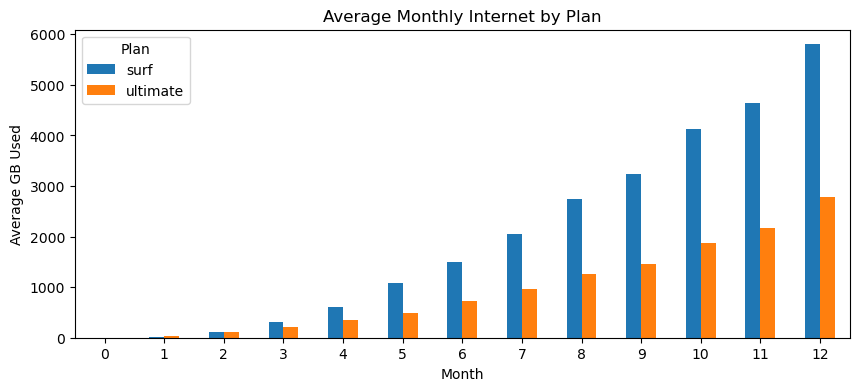

In [50]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
monthly_avg_calls = user_monthly_revenue.groupby(['plan_name','month'])['gb_per_month'].sum().reset_index()

# Convertimos los meses a enteros para que no se muestreen como float
monthly_avg_calls['month']  = monthly_avg_calls['month'].astype(int)

# Pivotamos para que cada columna sea un plan
monthly_avg_calls_pivot = monthly_avg_calls.pivot(index='month', columns='plan_name', values='gb_per_month')

monthly_avg_calls_pivot.plot(kind='bar', figsize=(10,4))

plt.title('Average Monthly Internet by Plan')
plt.xlabel('Month')
plt.ylabel('Average GB Used')
plt.legend(title='Plan')
plt.xticks(rotation=0)
plt.show()


Podemos observar en el gráfico que los usuarios del plan `Surf` tienden a consumir una mayor cantidad de datos al mes.

## Ingreso

Realizamos el análisis de datos con respecto a ambos planes para ver si existen diferencias en los ingresos.

In [51]:
#  Analiza los datos estadísticos de los ingresos mensuales por plan
user_monthly_revenue.groupby('plan_name')['revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
plan_name,,,,,,,,
surf,1579.0,60.178619,55.214537,20.0,20.0,40.0,80.0,588.66
ultimate,724.0,72.301105,11.364839,70.0,70.0,70.0,70.0,182.00


Como vemos en los datos el plan `surf` tiene el doble de usuarios que el plan `ultimate`.
El promedio de ingresos de los usurios del plan `surf` es mas elevado por servicios adicionales, mientras que el plan `ultimate` mantiene un promedio cercano al costo del plan.

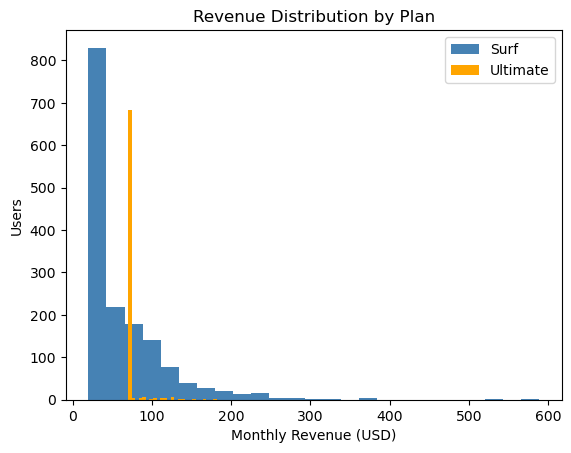

In [52]:
surf_revenue = user_monthly_revenue[user_monthly_revenue['plan_name'] == 'surf']['revenue']
ultimate_revenue = user_monthly_revenue[user_monthly_revenue['plan_name'] == 'ultimate']['revenue']

# Graficar
plt.hist(surf_revenue, bins=25, label='Surf', color='steelblue')
plt.hist(ultimate_revenue, bins=25, label='Ultimate', color='orange')

plt.title('Revenue Distribution by Plan')
plt.xlabel('Monthly Revenue (USD)')
plt.ylabel('Users')
plt.legend()
plt.show()

Podemos ver en la gráfica tenemos un sesgo positivo a la derecha para ambos planes, aunque es mas notorio para el plan `surf` lo que indica que un pequeño grupo usuarios generan mas ingresos por el consumo excesivo de algunos de los adicionales que ofrece la empresa, mientras que los usuarios del plan `ultimate` mantienen un nivel de ingresos constantes y cercanos al monto de la suscripción del plan.

## Prueba las hipótesis estadística

Realizaremos la prueba de hipótesis: los ingresos promedio generados por los usuarios de ambos planes son diferentes.

Para esto usaremos una `hipótesis nula:` Los ingresos promedio de ambos planes son iguales,
y una `hipótesis alternativa:` Los ingresos promedio de ambos planes son diferentes.

In [53]:
# Prueba las hipótesis
surf_revenue = user_monthly_revenue[user_monthly_revenue['plan_name'] == 'surf']['revenue']
ultimate_revenue = user_monthly_revenue[user_monthly_revenue['plan_name'] == 'ultimate']['revenue']

alpha = 0.05

results = st.ttest_ind(surf_revenue, ultimate_revenue,equal_var=False)

print('valor p: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")
    

valor p:  1.3513063978147017e-16
Rechazamos la hipótesis nula


Podemos observar por el análisis de datos que el promedio de ingresos de ambos planes no son iguales, por lo que descartamos la hipótesis nula que planteamos y confirmamos la hipótesis alternativa planteada.

Realizaremos la prueba de hipótesis: el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

Para esto usaremos una `hipótesis nula:` el ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones, y una `hipótesis alternativa:` el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

In [54]:
# Prueba las hipótesis
ny_nj_revenue = user_monthly_revenue[user_monthly_revenue['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue']
other_revenue = user_monthly_revenue[user_monthly_revenue['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['revenue']


alpha = 0.05

results = st.ttest_ind(ny_nj_revenue, other_revenue,equal_var=False)

print('valor p: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p:  0.03610610092900091
Rechazamos la hipótesis nula


## Conclusión general

Tras el análisis del comportamiento los clientes de Megaline durante el año 2018, se encontró que:

1.-El plan `surf` genera ingresos promedio significativamente mayores que el plan `ultimate`, ya que cuenta un mayor número de usuarios. Algunos tienden a exceder los límites incluidos y pagan tarifas adicionales, lo que eleva los ingresos de este plan.

2.-La diferencia en ingresos promedio entre ambos planes es estadísticamente significativa.

3.-Los ingresos promedio de los usuarios del área NY-NJ no son significativamente diferentes a los del resto del país, por lo que la región no parece ser un factor clave en los ingresos.
